[View in Colaboratory](https://colab.research.google.com/github/sbanerjee2020/NST/blob/master/6_Artistic_style_transfer_with_a_repurposed_VGG_Net_16.ipynb)

# Convolutional neural networks for artistic style transfer

This notebook is an implementation of a popular paper ([Gatys et al., 2015](https://arxiv.org/abs/1508.06576)) that demonstrates how to use neural networks to transfer artistic style from one image onto another. 

In [0]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

## Load and preprocess the content and style images

Our first task is to load the content and style images. Note that the content image we're working with is not particularly high quality, but the output we'll arrive at the end of this process still looks really good.

In [0]:
from PIL import Image
import requests

In [0]:
height = 512
width = 512

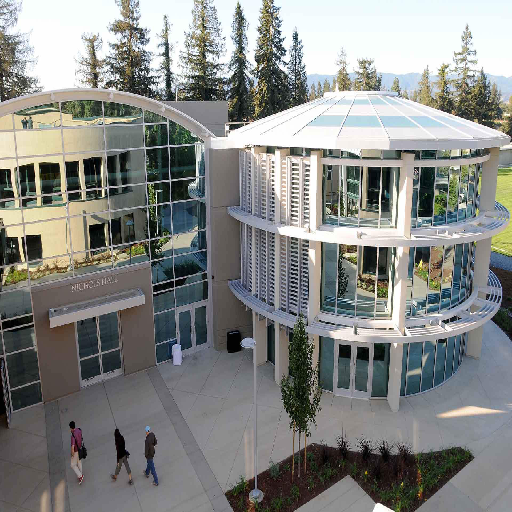

In [67]:
content_image_url = 'https://github.com/sbanerjee2020/NST/blob/master/images/harker.jpg?raw=true'
content_image_from_url = Image.open(requests.get(content_image_url, stream=True).raw)
content_image_from_url = content_image_from_url.resize((height, width))

content_image_from_url

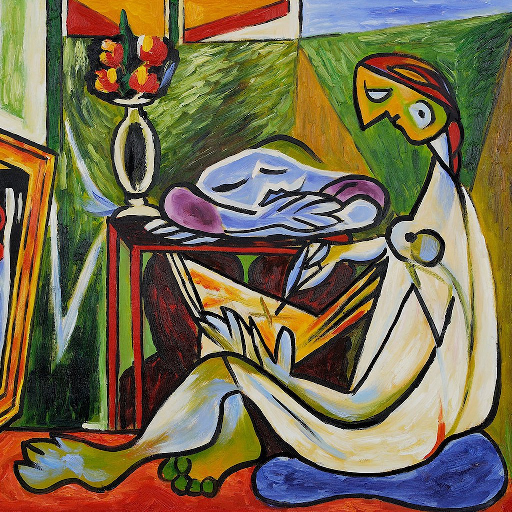

In [68]:
style_image_url = 'https://github.com/sbanerjee2020/NST/blob/master/images/styles/picasso.jpg?raw=true'
style_image_from_url = Image.open(requests.get(style_image_url, stream=True).raw)
style_image_from_url = style_image_from_url.resize((height, width))

style_image_from_url

Then, we convert these images into a form suitable for numerical processing. In particular, we add another dimension (beyond the classic height x width x 3 dimensions) so that we can later concatenate the representations of these two images into a common data structure.

In [69]:
content_array = np.asarray(content_image_from_url, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image_from_url, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


Before we proceed much further, we need to massage this input data to match what was done in [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), the paper that introduces the *VGG Network* model that we're going to use shortly.

For this, we need to perform two transformations:

1. Subtract the mean RGB value (computed previously on the [ImageNet training set](http://image-net.org) and easily obtainable from Google searches) from each pixel.
2. Flip the ordering of the multi-dimensional array from *RGB* to *BGR* (the ordering used in the paper).

In [0]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

Now we're ready to use these arrays to define variables in Keras' backend (the TensorFlow graph). We also introduce a placeholder variable to store the *combination* image that retains the content of the content image while incorporating the style of the style image.

In [0]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Finally, we concatenate all this image data into a single tensor that's suitable for processing by Keras' VGG16 model.

In [0]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

## Reuse a model pre-trained for image classification to define loss functions

The core idea introduced by [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576) is that convolutional neural networks (CNNs) pre-trained for image classification already know how to encode perceptual and semantic information about images. We're going to follow their idea, and use the *feature spaces* provided by one such model to independently work with content and style of images.

The original paper uses the 19 layer VGG network model from [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), but we're going to instead follow [Johnson et al. (2016)](https://arxiv.org/abs/1603.08155) and use the 16 layer model (VGG16). There is no noticeable qualitative difference in making this choice, and we gain a tiny bit in speed.

Also, since we're not interested in the classification problem, we don't need the fully connected layers or the final softmax classifier. We only need the part of the model marked in green in the table below.

![VGG Network Architectures](https://github.com/sbanerjee2020/NST/blob/master/images/vgg-architecture.png?raw=true "VGG Network Architectures")

It is trivial for us to get access to this truncated model because Keras comes with a set of pretrained models, including the VGG16 model we're interested in. Note that by setting `include_top=False` in the code below, we don't include any of the fully connected layers.

In [0]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

As is clear from the table above, the model we're working with has a lot of layers. Keras has its own names for these layers. Let's make a list of these names so that we can easily refer to individual layers later.

In [74]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_3/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_3/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_3/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_3/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_3/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_3/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_3/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_3/Relu:0' shape=(3, 64, 64, 51

If you stare at the list above, you'll convince yourself that we covered all items we wanted in the table (the cells marked in green). Notice also that because we provided Keras with a concrete input tensor, the various TensorFlow tensors get well-defined shapes.

---

The crux of the paper we're trying to reproduce is that the [style transfer problem can be posed as an optimisation problem](https://harishnarayanan.org/writing/artistic-style-transfer/), where the loss function we want to minimise can be decomposed into three distinct parts: the *content loss*, the *style loss* and the *total variation loss*.

The relative importance of these terms are determined by a set of scalar weights. These are  arbitrary, but the following set have been chosen after quite a bit of experimentation to find a set that generates output that's aesthetically pleasing to me.

In [0]:
content_weight = 0.075
style_weight = 15.0
total_variation_weight = 1.0

We'll now use the feature spaces provided by specific layers of our model to define these three loss functions. We begin by initialising the total loss to 0 and adding to it in stages.

In [0]:
loss = backend.variable(0.)

### The content loss

For the content loss, we follow Johnson et al. (2016) and draw the content feature from `block2_conv2`, because the original choice in Gatys et al. (2015) (`block4_conv2`) loses too much structural detail. And at least for faces, I find it more aesthetically pleasing to closely retain the structure of the original content image.

This variation across layers is shown for a couple of examples in the images below (just mentally replace `reluX_Y` with our Keras notation `blockX_convY`).

![Content feature reconstruction](https://github.com/sbanerjee2020/NST/blob/master/images/content-feature.png?raw=true "Content feature reconstruction")

The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

### The style loss

This is where things start to get a bit intricate.

For the style loss, we first define something called a *Gram matrix*. The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. By only capturing these aggregate statistics across the image, they are blind to the specific arrangement of objects inside the image. This is what allows them to capture information about style independent of content. (This is not trivial at all, and I refer you to [a paper that attempts to explain the idea](https://arxiv.org/abs/1606.01286).)

The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.


In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

The style loss is then the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images.

Again, in the following code, I've chosen to go with the style features from layers defined in Johnson et al. (2016) rather than Gatys et al. (2015) because I find the end results more aesthetically pleasing. I encourage you to experiment with these choices to see varying results.

In [0]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### The total variation loss

Now we're back on simpler ground.

If you were to solve the optimisation problem with only the two loss terms we've introduced so far (style and content), you'll find that the output is quite noisy. We thus add another term, called the [total variation loss](http://arxiv.org/abs/1412.0035) (a regularisation term) that encourages spatial smoothness.

You can experiment with reducing the `total_variation_weight` and play with the noise-level of the generated image.

In [0]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

## Define needed gradients and solve the optimisation problem

[The goal of this journey](https://harishnarayanan.org/writing/artistic-style-transfer/) was to setup an optimisation problem that aims to solve for a *combination image* that contains the content of the content image, while having the style of the style image. Now that we have our input images massaged and our loss function calculators in place, all we have left to do is define gradients of the total loss relative to the combination image, and use these gradients to iteratively improve upon our combination image to minimise the loss.

We start by defining the gradients.

In [0]:
grads = backend.gradients(loss, combination_image)

We then introduce an `Evaluator` class that computes loss and gradients in one pass while retrieving them via two separate functions, `loss` and `grads`. This is done because `scipy.optimize` requires separate functions for loss and gradients, but computing them separately would be inefficient.

In [0]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Now we're finally ready to solve our optimisation problem. This combination image begins its life as a random collection of (valid) pixels, and we use the [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon it.

We stop after 10 iterations because the output looks good to me and the loss stops reducing significantly.

In [83]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 441287000000.0
Iteration 0 completed in 20s
Start of iteration 1
Current loss value: 245288270000.0
Iteration 1 completed in 19s
Start of iteration 2
Current loss value: 158277470000.0
Iteration 2 completed in 19s
Start of iteration 3
Current loss value: 126773010000.0
Iteration 3 completed in 19s
Start of iteration 4
Current loss value: 108161100000.0
Iteration 4 completed in 19s
Start of iteration 5
Current loss value: 98879770000.0
Iteration 5 completed in 19s
Start of iteration 6
Current loss value: 93527740000.0
Iteration 6 completed in 19s
Start of iteration 7
Current loss value: 90550075000.0
Iteration 7 completed in 19s
Start of iteration 8
Current loss value: 88595130000.0
Iteration 8 completed in 19s
Start of iteration 9
Current loss value: 87201630000.0
Iteration 9 completed in 19s


This took a while on my piddly laptop (that isn't GPU-accelerated), but here is the beautiful output from the last iteration! (Notice that we need to subject our output image to the inverse of the transformation we did to our input images before it makes sense.)

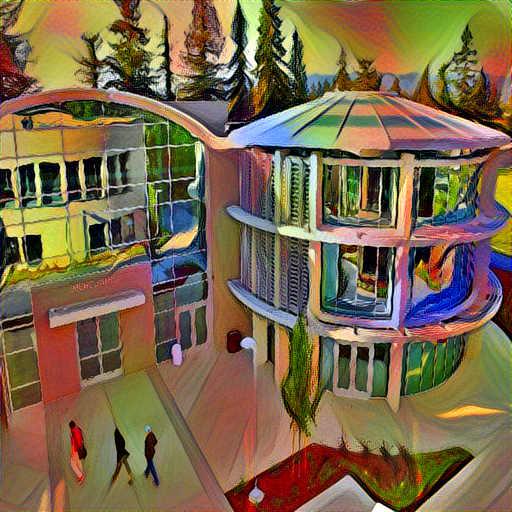

In [84]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

## Conclusion and further improvements

It's now your turn to play! Try changing the input images, their sizes, the weights of the different loss functions, the features used to construct them and enjoy different sorts of output.

As beautiful as the output of this code can be, the process we use to generate it is quite slow. And no matter how much you speed this algorithm up (with GPUs and creative hacks), it is still going to be a relatively expensive problem to solve. This is because we're solving an entire optimisation problem each time we want to generate an image.
